In [23]:
import pandas as pd
import numpy as np

#first regression library, statsmodels
import statsmodels.api as sm

#secton regression library, sci-kit-learn
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression

# Importing data & prepping

In [2]:
# Importing the uber data
filename = "Data/boston-censustracts-2018-3-OnlyWeekdays-HourlyAggregate.csv"
table = pd.read_csv(filename)

# Getting a look at the new table
print(table.head())

   sourceid  dstid  hod  mean_travel_time  standard_deviation_travel_time  \
0         3      5   20            987.60                          355.46   
1         5      3    0           1014.14                          197.06   
2         5      3   16           1665.80                          381.10   
3         1     12    2            180.04                          109.52   
4         1     12   18            278.22                          192.63   

   geometric_mean_travel_time  geometric_standard_deviation_travel_time  
0                      933.95                                      1.38  
1                      996.06                                      1.21  
2                     1621.42                                      1.26  
3                      158.66                                      1.59  
4                      219.43                                      2.13  


### Generating variables

In [3]:
# Create "pairs" row, essentially as an id for the trip in question
table['pair'] = table.apply(lambda row: str(int(row['sourceid']))+'-'+str(int(row['dstid'])),axis=1).head()
print(table.head())

   sourceid  dstid  hod  mean_travel_time  standard_deviation_travel_time  \
0         3      5   20            987.60                          355.46   
1         5      3    0           1014.14                          197.06   
2         5      3   16           1665.80                          381.10   
3         1     12    2            180.04                          109.52   
4         1     12   18            278.22                          192.63   

   geometric_mean_travel_time  geometric_standard_deviation_travel_time  pair  
0                      933.95                                      1.38   3-5  
1                      996.06                                      1.21   5-3  
2                     1621.42                                      1.26   5-3  
3                      158.66                                      1.59  1-12  
4                      219.43                                      2.13  1-12  


In [4]:
# Creating the dummy variables for hour of day, to see the distinct effect of that particular hour on mean_travel_time
for x in np.nditer(table["hod"].unique()):
    table.loc[table.hod == int(x), (str(x)+"hr")] = int(1)
    table.loc[table.hod != int(x), (str(x)+"hr")] = int(0)

Side note: even though'hod' is a continuous variable, we're not trying to predice the marginal effect of a one unit increase in the hour of the day, but rather the effect that any given hour has on travel time: Essentially, we want to treat the time as a categorical variable. So, we need to dummy out all the hours of the day.

# Regressions
    Dependent: 'mean_travel_time'
    Independent: 'hod', dummied out into 24 binary variables
    
## using Statsmodels

In [21]:
# Adding an intercept column, to be assigned a single coeffecient by the model
table['Intercept'] = 1.0

# Statsmodels takes the DV and its IVs as Dataframes
DV = table["mean_travel_time"] # also the Y
IV = table[[
    'Intercept', '1hr','2hr','3hr','4hr','5hr','6hr','7hr','8hr','9hr','10hr',
    '11hr','12hr','13hr', '14hr','15hr','16hr','17hr','18hr','19hr','20hr',
    '21hr','22hr','23hr'
]] # also the X's

model = sm.OLS(DV,IV).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       mean_travel_time   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                 1.964e+04
Date:                Mon, 27 May 2019   Prob (F-statistic):               0.00
Time:                        17:53:56   Log-Likelihood:            -3.0643e+07
No. Observations:             3860011   AIC:                         6.129e+07
Df Residuals:                 3859987   BIC:                         6.129e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1009.6124      1.793    563.007      0.0

#### Notes/Issues
- When I include an intercept, *and* all 24 dummy variables, the the values soar, e.g. -1.4e10 becomes the only coeffecient, and +1.4e10 the intercept. Removing even a single hour dummy fixes this. Why? Could this be an issue of no baseline to compare to? e.g. there's no "when all treatments are absent, we get __"? For now, just removed midnight, which is functioning as the "without treatment" situation.

## using Sci-Kit Learn

In [25]:
# Creating the model
lm = LinearRegression() # creating a sklearn linear model

DV = table["mean_travel_time"] # also the Y
IV = table[[
    '1hr','2hr','3hr','4hr','5hr','6hr','7hr','8hr','9hr','10hr',
    '11hr','12hr','13hr', '14hr','15hr','16hr','17hr','18hr','19hr','20hr',
    '21hr','22hr','23hr'
]] # all the X's

lm.fit(IV,DV)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
#Querying the model
print(pd.DataFrame(list(zip(IV.columns, lm.coef_)),columns = ["Variable", "Coefficient"]))
print("constant: " + str(lm.intercept_))

   Variable  Coefficient
0       1hr   -76.180679
1       2hr  -134.798856
2       3hr  -131.298017
3       4hr   -81.006251
4       5hr    15.807079
5       6hr   223.254479
6       7hr   490.163254
7       8hr   482.025842
8       9hr   321.978955
9      10hr   250.073102
10     11hr   252.836420
11     12hr   283.248661
12     13hr   325.652549
13     14hr   498.986291
14     15hr   630.996052
15     16hr   706.604291
16     17hr   686.624473
17     18hr   439.192807
18     19hr   249.545144
19     20hr   180.110071
20     21hr   168.859068
21     22hr   159.653512
22     23hr   128.126052
constant: 1009.61243244


# Plots & Visualizations

Text(0,0.5,'Mean Trip Dur. (seconds)')

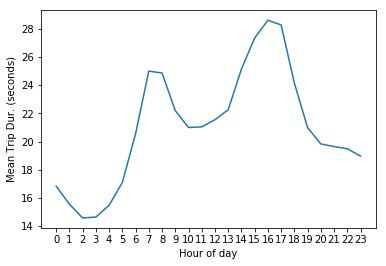

In [72]:
# Adjusting the data for visualization
y_values = np.insert(lm.coef_,0,0) # Adding midnight/0hr back in, as the baseline
y_values = y_values + lm.intercept_ # Shifting up all values by the constant, 
                                    # so now we have a graph of estimated mean travel time
y_values = y_values/60 # Converting to minutes, for readability

plt.plot(range(24),y_values)
plt.xlabel("Hour of day")
plt.xticks(range(24))
plt.ylabel("Mean Trip Dur. (min)")

plt.show()

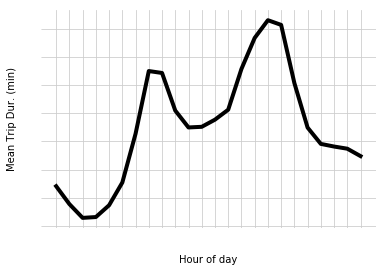

In [97]:
# Getting creative with the formatting
plt.plot(range(24),y_values, linewidth=4, color = "k")
plt.xlabel("Hour of day")
plt.xticks(range(24), rotation = 60)
plt.ylabel("Mean Trip Dur. (min)")

plt.grid(axis="both",color="0.8")


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(colors="w")


plt.show()

# Notes, Issues, and Areas for Improvement
- What this fails to account for is how some trips might be more popular at certain hours, e.g. say if longer trips (in both distance and time) happen to take place in the mid day period, but not at night, this would lead to an artificial inflation of the effect of those hours on travel time.